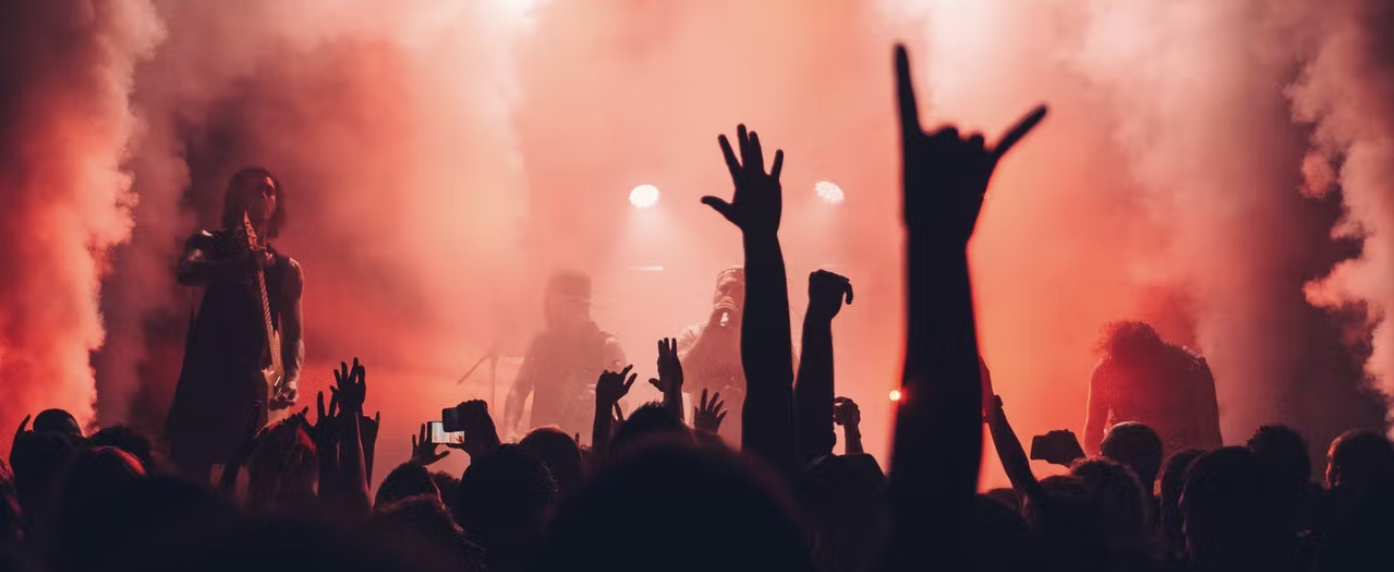

# Spotify

**Author:** Dermot O'Brien
***

## Overview


Spotify is not profitable. There largest expenses are the licensing fees paid to major record labels that allow Spotify to stream their clients music. Is there a way Spotify can reduce these licensing fee's? 60,000 songs are uploaded to Spotify's platform daily, giving Spotify early access to data unseen by other interested parties. If spotify were able to recgonize talent on their own using this competatively advantageous data, they could potentially discover unrecognized artists with high potential before the record labels, create their own record label and sign these hidden gems, and reduce/avoid the high licensing costs paid to labels. If changing their business model is too large of a task, they can at the very least understand which songs and artists to bolser with funding and team support to maximize streams and optimize resource allocation.

## Business Problem

To ensure the success of Spotify’s own label, they need to be able to instantaneously - on first upload to the database - decide whether or not a song will be a success. As a consultant of Spotify, I will work to create a model that can be used by Spotify that recgonizes those high-potential hit songs based on Spotify's own data - specifically audio features and spotify-specific features. 

## I. Data Importing and Dataframe Creation
To create the dataframe used for modeling, three steps will be required. First, I will need to pull a list of id's from Kaggle's [Every Noise at Once Dataset](https://www.kaggle.com/datasets/nikitricky/every-noise-at-once/discussion?select=songs.csv) that can pass through a tool called spotipy - a python library connected to Spotify's Web API. Note that I will only be using data between January 2020 and September 2021 for relevance purposes. Next, I will pass the list of id's through spotipy's `.audio_features` method and create a features dataframe. Finally, I'll pass the list of id's through spotipy's `.tracks` method to create a popularity dataframe. After concatenating these two dataframes, we will have a comprehensive dataframe to begin our analysis. For a cleaner notebook, I've created the features and popularity dataframes in an alternate notebook. If you are interested in learning how to get spotify api authorization and how to pull data through spotipy, refer to my walkthrough/guide notebook [here]().

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import base64
import requests
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import MissingIndicator
import xgboost as xgb
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

### Dataframe Creation
To create the features and popularity dataframes, I first needed to use for loops to retreive the data since spotify's api can only pull 50-100 rows at a time depending on the method. Since the `.tracks` method's output is a messy lists of dictionaries, we'll need a nested for loop. For documentation, please refer to the *Kaggle Investigation* notebook. The final dataframe before eda and data prep, labeled df, will be a concat of popularity_df and features_df. 

In [2]:
# Pull the dataframes created in the Kaggle Investigation Notebook
popularity_df = pd.read_csv('./Data/target_df')
features_df = pd.read_csv('./Data/features_df')

In [3]:
# Drop duplicates in features_df
features_df.drop_duplicates(subset=['id'], inplace=True)

In [4]:
# Merge dataframes on id
df = pd.merge(features_df, popularity_df, on ='id')

Due to the merge, we have roughly 20,000 rows with no popularity values. We'll go ahead and drop those before EDA

In [5]:
# Check for 0 values in popularity column
df[df['popularity'] == 0].shape

(20040, 19)

In [6]:
# Drop columns from popularity column with values of 0
df = df[df.popularity != 0]

In [7]:
# Reset the index
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

## II. Data Understanding


### Column Names and Understanding
* `danceability`: [str] Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable.
* `energy`: [float] Represents a perceptual measure of intensity and activity. A measure from 0.0 to 1.0.
* `key`: [int] The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* `loudness`: [float] The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 db.
* `mode`: [int] Modality of a track. Major is represented by 1 and minor is 0.
* `speechiness`: [float] Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* `accousticness`: [float] A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* `instrumentalness`: [float] Predicts whether a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* `liveness`: [float] Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* `valence`: [float] A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive.
* `tempo`: [float] The overall estimated tempo of a track in beats per minute (BPM).
* `type`: [str] The object type (audio_features)
* `id`: [str] The Spotify ID for the track.
* `uri`: [str] The Spotify URI for the track.
* `track_href`: [str] A link to the Web API endpoint providing full details of the track.
* `analysis_url`: [str] A URL to access the full audio analysis of this track. An access token is required to access this data.
* `duration_ms`: [int] The duration of the track in milliseconds.
* `time_signature`: [int] An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
* `popularity`: [int] The target variable. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

Let's start by examining the data to see how it can be cleaned. Odds are we won't need all of the columns mentioned above, some having little useful information and others being descriptive and non-numeric.

In [8]:
# Check the shape of the df
df.shape

(66045, 19)

In [9]:
# Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66045 entries, 0 to 66044
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      66045 non-null  float64
 1   energy            66045 non-null  float64
 2   key               66045 non-null  int64  
 3   loudness          66045 non-null  float64
 4   mode              66045 non-null  int64  
 5   speechiness       66045 non-null  float64
 6   acousticness      66045 non-null  float64
 7   instrumentalness  66045 non-null  float64
 8   liveness          66045 non-null  float64
 9   valence           66045 non-null  float64
 10  tempo             66045 non-null  float64
 11  type              66045 non-null  object 
 12  id                66045 non-null  object 
 13  uri               66045 non-null  object 
 14  track_href        66045 non-null  object 
 15  analysis_url      66045 non-null  object 
 16  duration_ms       66045 non-null  int64 

In [10]:
# Check the statistics of numerical columns
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,66045.000000,66045.000000,66045.00000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,6.604500e+04,66045.000000,66045.000000
mean,0.595497,0.635435,5.30673,-8.567336,0.576622,0.101893,0.285464,0.204847,0.183175,0.453260,122.413112,2.326026e+05,3.920282,20.846847
std,0.189874,0.238108,3.57791,4.925100,0.494098,0.098069,0.311962,0.344674,0.143367,0.253812,29.253738,9.354251e+04,0.397993,16.860289
min,0.000000,0.000221,0.00000,-53.885000,0.000000,0.000000,0.000000,0.000000,0.011300,0.000000,0.000000,3.163200e+04,0.000000,1.000000
25%,0.473000,0.487000,2.00000,-10.137000,0.000000,0.039100,0.015300,0.000000,0.097100,0.242000,99.889000,1.770370e+05,4.000000,5.000000
50%,0.620000,0.660000,5.00000,-7.526000,1.000000,0.058700,0.155000,0.000205,0.123000,0.442000,122.016000,2.113420e+05,4.000000,17.000000
75%,0.742000,0.828000,8.00000,-5.566000,1.000000,0.125000,0.496000,0.286000,0.227000,0.653000,140.070000,2.610960e+05,4.000000,33.000000
max,0.985000,1.000000,11.00000,5.968000,1.000000,0.966000,0.996000,1.000000,0.986000,0.991000,236.196000,2.441813e+06,5.000000,89.000000


### Danceability

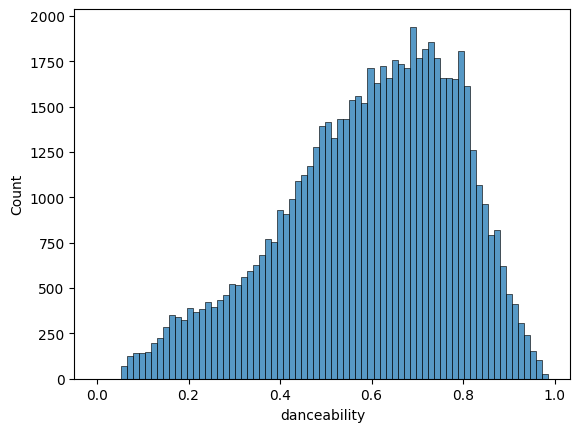

In [11]:
sns.histplot(df.danceability);

### Energy

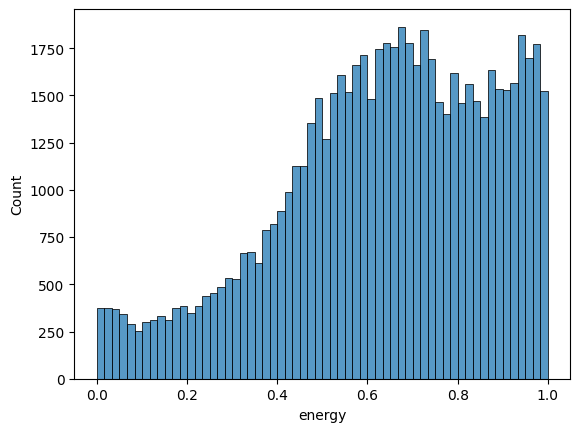

In [12]:
sns.histplot(df.energy);

### Key

In [13]:
df.key.value_counts(normalize=True, ascending=False)

1     0.115573
7     0.108971
0     0.104580
2     0.096253
9     0.095359
11    0.085260
5     0.078159
6     0.076221
4     0.075706
8     0.066440
10    0.066409
3     0.031070
Name: key, dtype: float64

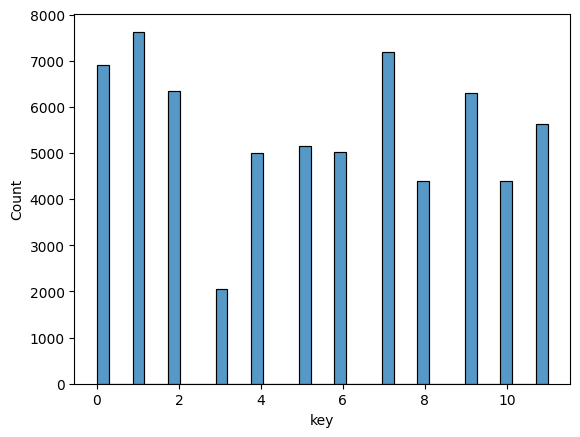

In [14]:
sns.histplot(df.key);

### Loudness

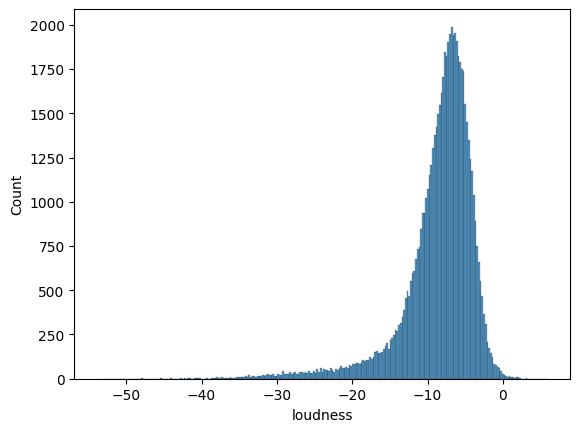

In [15]:
sns.histplot(df.loudness);

### Mode

In [16]:
# Major key = 1 and Minor key = 0
df['mode'].value_counts(normalize=True)

1    0.576622
0    0.423378
Name: mode, dtype: float64

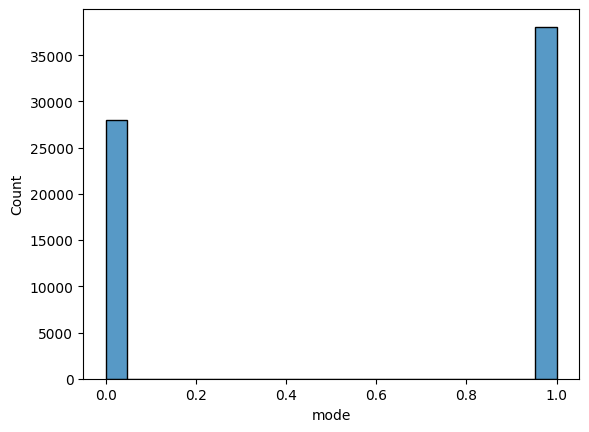

In [17]:
sns.histplot(df['mode']);

### Speechiness

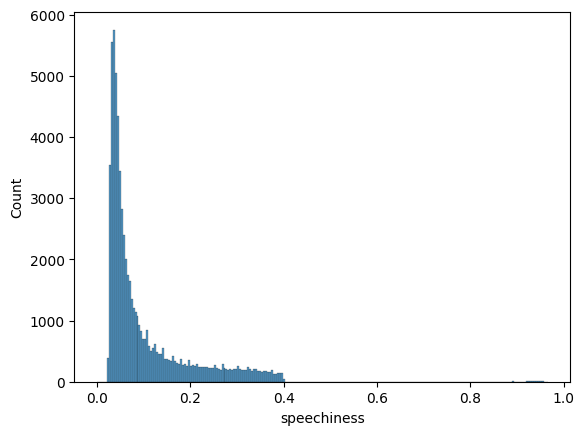

In [18]:
sns.histplot(df.speechiness);

### Acousticness

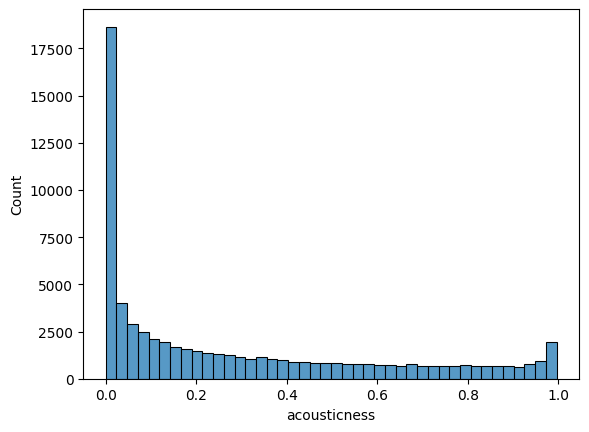

In [19]:
sns.histplot(df.acousticness);

### Instrumentalness

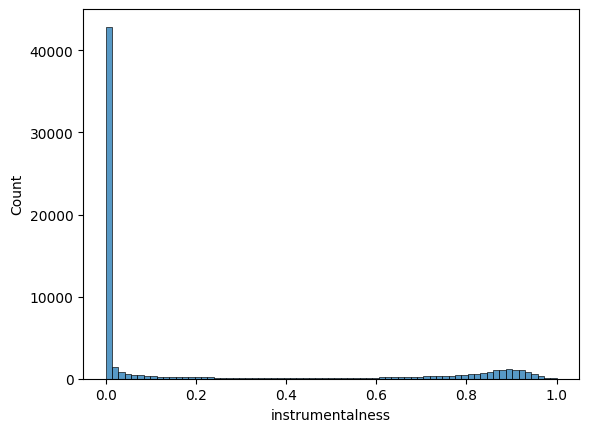

In [20]:
sns.histplot(df.instrumentalness);

### Liveness

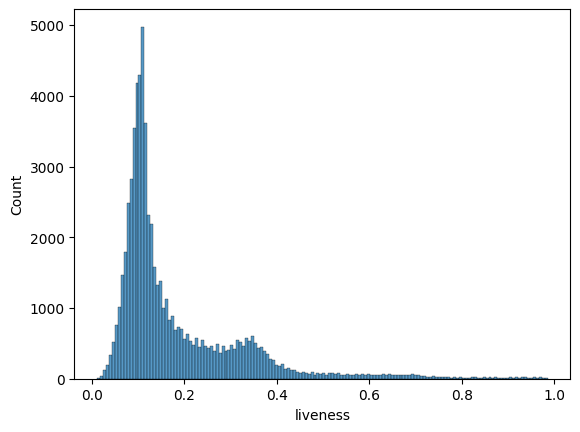

In [21]:
sns.histplot(df.liveness);

### Valence

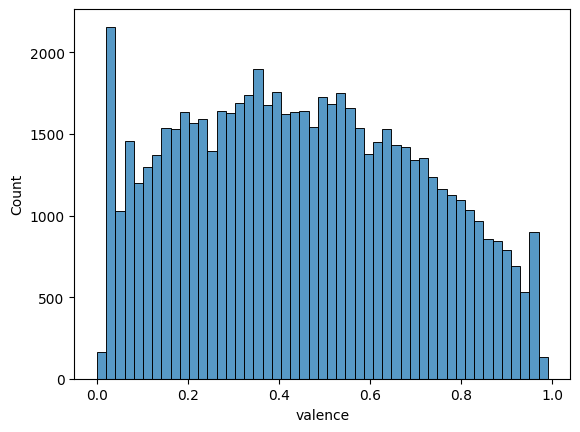

In [22]:
sns.histplot(df.valence);

### Tempo

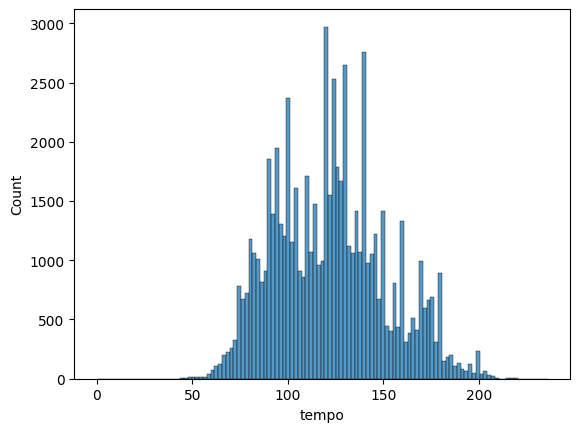

In [23]:
sns.histplot(df.tempo);

### Duration

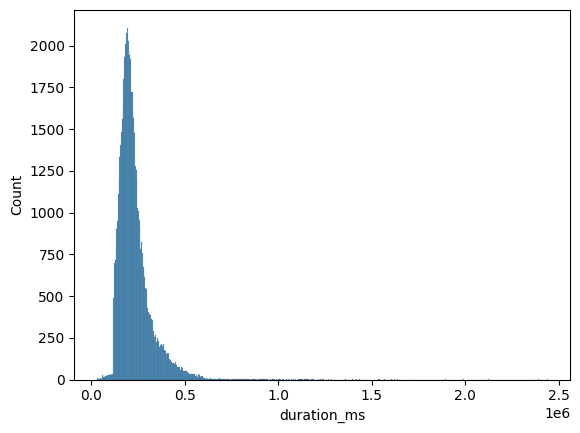

In [24]:
sns.histplot(df['duration_ms']);

### Time Signature

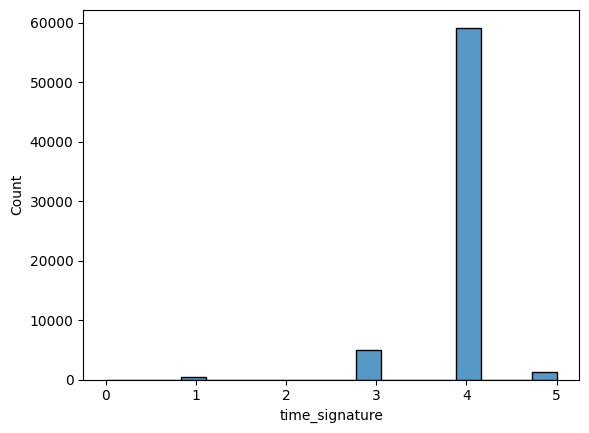

In [25]:
sns.histplot(df.time_signature);

### Popularity

In [26]:
df.popularity.value_counts(normalize=True)

1     0.085760
2     0.057582
3     0.044046
4     0.035415
5     0.029374
        ...   
84    0.000061
87    0.000045
88    0.000015
89    0.000015
86    0.000015
Name: popularity, Length: 89, dtype: float64

In [27]:
df[df['popularity'] == 1].shape

(5664, 19)

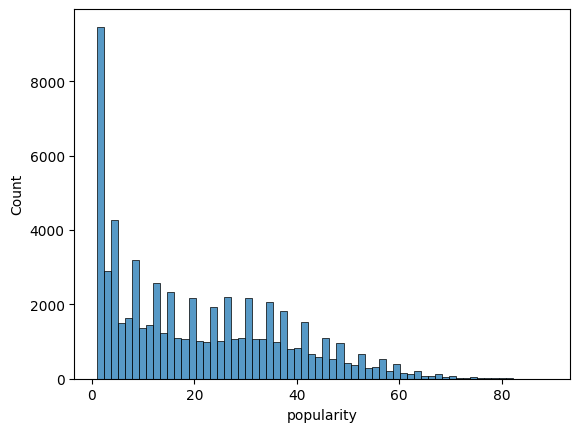

In [28]:
sns.histplot(df.popularity);

In [29]:
test_df = df[df['popularity'] > 4]

In [30]:
test_df.shape

(51330, 19)

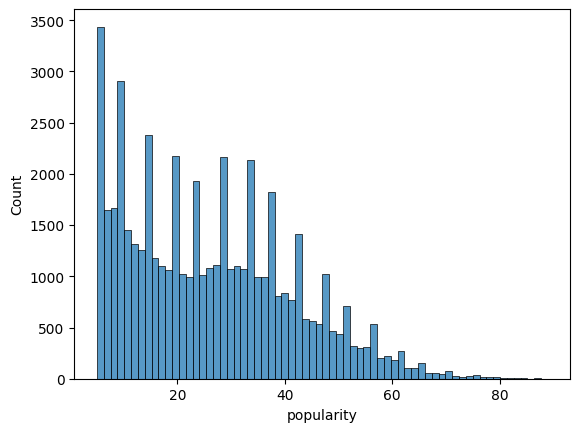

In [31]:
sns.histplot(test_df.popularity);

## III. Data Preparation
I'll need to add a binary column that indicates whether a song is a "hit" or not. This will be classified by songs with a popularity score > 50. Since were looking at older songs (Jan 2020 - Sept 2021), I lowered the threshold of popularity since the algorithim from spotify adds more weight to recent streams.

* `hit`: new column - indicates if that song is a hit or not

Let's also drop inutile columns:
* `key`: looks somewhat equally distributed
* `time_signature`: mostly all songs have a time signature of 4
* `popularity`: since we changed this to a binary (Hit or no hit), we can drop this column
* None-numeric columns to drop: `type`, `id`, `uri`, `track_href`, `analysis_url`

In [32]:
# Change duration_ms to duration_s, milliseconds to seconds conversion
df['duration_ms'] = df['duration_ms'].div(1000).round()

In [33]:
df.rename(columns={'duration_ms':'duration_s'}, inplace=True)

In [34]:
# Before dropping columns, make a copy of the dataframe for visuals (need popularity column)
df_radar = df.copy()

In [35]:
# Create a new column for 'hit'
df['hit'] = np.where(df['popularity'] >= 50, 1, 0)

In [36]:
# Check to see if the new column works correctly
df.loc[df['popularity'] >= 50, ['hit']].min() == df.loc[df['popularity'] >= 50, ['hit']].max()

hit    True
dtype: bool

In [37]:
df.loc[df['popularity'] < 50, ['hit']].min() == df.loc[df['popularity'] < 50, ['hit']].max()

hit    True
dtype: bool

In [38]:
# Create a copy to pull data for future vizualizations
df_copy = df.copy()

In [39]:
# Drop inutile columns for df
df.drop(['key', 
         'time_signature', 
         'popularity', 
         'type', 
         'id', 
         'uri', 
         'track_href',
         'analysis_url'], axis=1, inplace=True)

In [40]:
# Check to see if that worked, should now have 12 columns
df.shape

(66045, 12)

### Data Analysis Visualizations

#### Radar Chart (Spider Chart)

In [41]:
# Radar Chart Setup
df_radar['hit'] = np.where(df_radar['popularity'] >= 75, 1, 0)

In [42]:
# Drop inutile columns for df
df_radar.drop(['key', 
         'time_signature', 
         'popularity', 
         'type', 
         'id', 
         'uri', 
         'track_href',
         'analysis_url',
         'mode'], axis=1, inplace=True)

In [43]:
# minmax scale the data
mmscaler = MinMaxScaler()
radar_scaled = mmscaler.fit_transform(df_radar[['danceability',
                                 'energy',
                                 'loudness',
                                 'speechiness',
                                 'acousticness',
                                 'instrumentalness',
                                 'liveness',
                                 'valence',
                                 'tempo',
                                 'duration_s']])
df_radar_scaled = pd.DataFrame(radar_scaled)

In [44]:
# Rename columns
df_radar_scaled.rename(columns={0:'danceability',
                                1:'energy',
                                2:'loudness',
                                3:'speechiness',
                                4:'acousticness',
                                5:'instrumentalness',
                                6:'liveness',
                                7:'valence',
                                8:'tempo',
                                9:'duration_seconds'}, inplace=True)

In [45]:
# Add hit back
hit_column = df_radar['hit']
df_radar_scaled['hit'] = hit_column.values

In [46]:
# Create a dataframe for Hit Songs, drop Hit column
df_radar_hit = df_radar_scaled.loc[df_radar_scaled['hit'] == 1]
df_radar_hit.drop('hit', axis=1, inplace=True)

In [47]:
# Create a dataframe for Not Hit Songs, drop Hit column
df_radar_nohit = df_radar_scaled.loc[df_radar_scaled['hit'] == 0]
df_radar_nohit.drop('hit', axis=1, inplace=True)

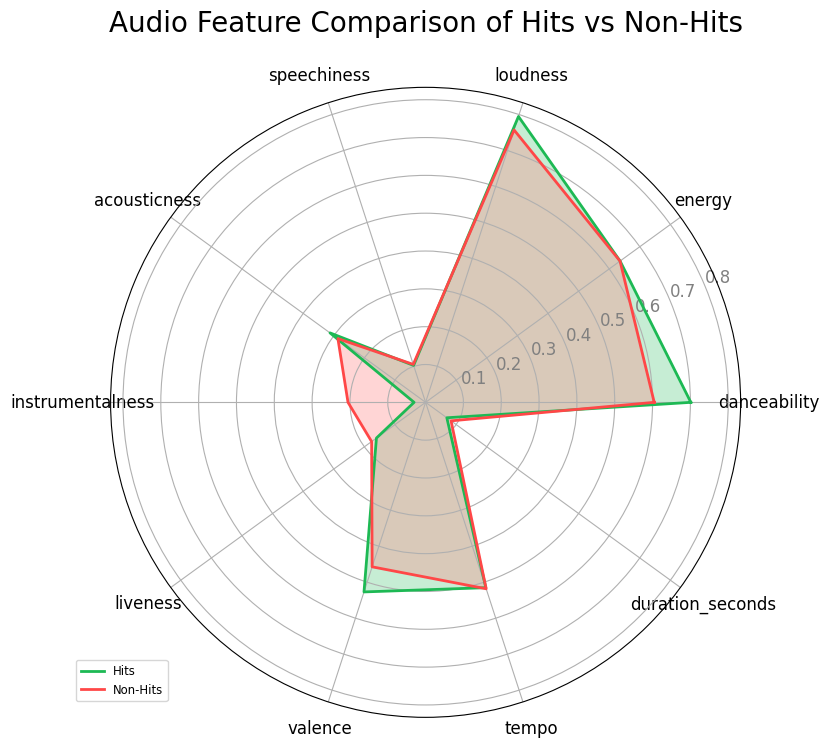

In [48]:
# Create a Radar chart using matplotlib

# Set data
# Convert column names into a list
categories = list(df_radar_hit.columns)
# number of categories
N = len(categories)

# Create a list with the average of all features
value_hit = list(df_radar_hit.mean())
value_nohit = list(df_radar_nohit.mean())

# Repeat first value to close the circle
# The plot is a circle, so we need to "complete the loop" and append the start value to the end
value_hit+=value_hit[:1]
value_nohit+=value_nohit[:1]

# Calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(221, polar=True)

#Plot 1 - Hits
ax.plot(angles, value_hit,  linewidth=2, label="Hits", color='#1DB954')
ax.fill(angles, value_hit, alpha=0.25, facecolor='#1DB954')

#Plot 2 Non-Hits
ax.plot(angles, value_nohit, linewidth=2, label = "Non-Hits", color='#ff4747')
ax.fill(angles, value_nohit, alpha=0.35, facecolor='#f88' )

ax.set_title('Audio Feature Comparison of Hits vs Non-Hits', size=20, pad=40)
ax.grid(True)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='small')

# Add axis ticks
plt.xticks(angles[:-1],categories, size=12)
ax.tick_params(axis='x', which='major', pad=10)
plt.yticks(color='grey',size=12)


# Create a color palette:
plt.cm.get_cmap("Set2", len(df_radar_hit.index))

# Save Figure
plt.savefig('./Visuals/Audoio_Features_Radar_Chart.png', bbox_inches='tight',transparent=True)

# Show Figure
plt.show();

## IV. Data Modeling
Now that our data is clean, its time for modeling. Since I will want to know which features are most impacting the models predictions, I am going to use tree-based models. This will allow me to pull feature importances later on.

### Modeling Evaluation Metric - Precision
As we iterate our models, it is important to distinguish which evaluation metric we want to focus on maximizing.  Music labels want to maximize the ability to predict a hit song correctly. It is more important that they predict a hit correctly, opposed to missing out on a song that eventually becomes a hit. In this instance, precision is most important to Spotify's bottom line. Remember that precision in our context evaluates how well our model correctly predicts whether a song will be a hit or not:

Precision = True positives / (True positives + False positives)
* Basically, of all of our predicted hit songs, how many were actually hit songs?

Recall = True positives / (True positives + False negatives)
* Recall measures how many actual hits we predicted correctly.

If we classified a song as a non-hit, but then it becomes a hit (false negative), we're not losing much monetarily given we never actually invested time/resources into that song/artist. On the other hand, if we predict a song is a hit and it ends up being a flop (false positive) we have now lost a lot of time and money on a dud. The later scenario is one that we want to minimize, which is why we are focusing on precision.

### Train Test Split
To see how the model performs on unseen data, we will train test split. Basically taking 75% of the data for training and 25% for testing.

In [49]:
# Create variables and split data into training and testing
X = df.drop('hit', axis=1)
y = df['hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### Class Setup for Model Evaluation
The code below is from a Flatiron lecture, with adjustments to fit my projects needs. It is a cross validation class that we can run on each iteration of our model to evaluate its accuracy, presicion, and recall. This will be helpful, allowing us to compare each iteration to see if changes had positive effects on the model.

In [50]:
# Create a Class to evaluate each model with cross validation
# This plot was taken from flatiron school's curriculum team and adapted by our team to fit our needs

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # cross validate immediately when an object is created or not
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        return cv_summary

### Dummy Model
We're going to start our modeling by creating a dummy model - in this instance - a model that predicts the most frequent class everytime. This is going to give us an accuracy % that is equal to our negative class (non-hit songs). This will act as a baseline, although since we're not necessarily focused on accuracy it won't be as useful.

In [51]:
# Dummy Model that predicts all observations to be in the class with the most frequent values (not a hit)
dummy_model_mf = DummyClassifier(strategy='most_frequent', constant=1)
dummy_model_mf.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='most_frequent')

In [52]:
# Evaluate dummy mf model with CV
dummy_mf_results = ModelWithCV(model=dummy_model_mf,
                         model_name='dummy_mf_results',
                         X=X_train,
                         y=y_train)

dummy_mf_results.print_cv_summary();

CV Results for `dummy_mf_results` model:
             0.93537 accuracy
             0.00000 recall
             0.00000 precision
        


### Pipeline Setup

Creating this pipeline will allow us to make changes in a more efficient manner, simplifying the process of itereating models and tuning individual pipelines as needed.

In [53]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
num_pipeline = Pipeline(steps=[ ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [54]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, 
                                          ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']),
                                     ('cat_pipeline', cat_pipeline, 
                                          ['mode'])], remainder='passthrough')

### Decision Trees
Let's begin our modeling with a simple tree, the Decision Tree Classifier. Decision Trees handle classification problems by splitting the recursively asking simple true or false questions until the data is split into the purest possible subgroups. Let's see how it does without any hyperparameter tuning.

In [55]:
# Create a Decision Tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('decisiontree', DecisionTreeClassifier())])

In [56]:
# Evaluate Decision Tree model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary();

CV Results for `dtree_pipe` model:
             0.87480 accuracy
             0.12709 recall
             0.10209 precision
        


### Random Forest
Next we're going to use the RandomForestClassifier. Random Forest takes very large number of random/varying decision trees, hence "Forest", and then takes a vote among the different trees. Each tree spits out a class prediction, and then the clas with the most votes becomes the prediction of the random forest.

In [57]:
# Create a Random Forest model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('rfc', RandomForestClassifier())])

In [58]:
# Evaluate Random Forest model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary();

CV Results for `rfc_pipe` model:
             0.93616 accuracy
             0.01786 recall
             0.71911 precision
        


Not bad for a model with hyperparameter tuning. Let's do a gridsearch on some important hyperparameters to try to get a better precision score.

#### RF Grid Search 1

In [59]:
# Random Forest Grid Search 1
rf_grid_1 = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200]}

In [60]:
# Instantiate Random Forest Grid Search 1
rf_gs_1 = GridSearchCV(estimator=rfc_pipe, 
                     param_grid=rf_grid_1, 
                     cv=5, 
                     scoring='precision',
                     verbose=2,
                     n_jobs=-2)

In [61]:
# Fit data on the Random Forest Grid Search 1
# Markdown of results below, uncomment to run
# rf_gs_1.fit(X_train, y_train)

In [62]:
# Check best params - Markdown to avoid re-running
# rf_gs_1.best_params_

rf_gs_1.best_params
* rfc__max_depth': 5
* rfc__max_features': 'sqrt'
* rfc__min_samples_leaf': 1
* rfc__min_samples_split': 2
* rfc__n_estimators': 10

In [63]:
# Check best score - Markdown to avoid re-running
# rf_gs_1.best_score_

rf_gs_1.best_score_
* 0.88333

In [64]:
# Save best estimator to run cross validation on
# rf_gs_1_best = rf_gs_1.best_estimator_

In [65]:
# Evaluate Best RF GF 1 model with CV - Markdown to avoid re-running
# rf_gf_1_results = ModelWithCV(model=rf_gs_1_best,
#                          model_name='rf_gs_1',
#                          X=X_train,
#                          y=y_train)

# rf_gf_1_results.print_cv_summary();

CV Results for `rf_gs_1` model:
* 0.93544 accuracy
* 0.00747 recall
* 0.80000 precision

Our precision went up around 9 percentage points. Let's tune the hyperparameters even more.

#### RF Grid Search 2

In [66]:
# Random Forest Grid Search 2
rf_grid_2 = {'rfc__max_depth': [5],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1],
 'rfc__min_samples_split': [1, 2],
 'rfc__n_estimators': [10, 50, 70, 100]}

In [67]:
# Instantiate Random Forest Grid Search 2
rf_gs_2 = GridSearchCV(estimator=rfc_pipe, 
                     param_grid=rf_grid_2, 
                     cv=5, 
                     scoring='precision',
                     verbose=2,
                     n_jobs=-2)

In [68]:
# Fit data on the Random Forest Grid Search 2
# Markdown of results below, uncomment to run
# rf_gs_2.fit(X_train,y_train)

In [69]:
# Check best params - Markdown to avoid re-running
# rf_gs_2.best_params_

rf_gs_2.best_params
* rfc__max_depth': 5
* rfc__max_features': 'sqrt'
* rfc__min_samples_leaf': 1
* rfc__min_samples_split': 1
* rfc__n_estimators': 50

In [70]:
# Check best score - Markdown to avoid re-running
# rf_gs_2.best_score_

rf_gs_2.best_score_
* 0.90

In [71]:
# Save best estimator to run cross validation on
# rf_gs_2_best = rf_gs_2.best_estimator_

In [72]:
# Evaluate Best RF GF 1 model with CV
# rf_gf_2_results = ModelWithCV(model=rf_gs_2_best,
#                          model_name='rf_gs_2',
#                          X=X_train,
#                          y=y_train)

# rf_gf_2_results.print_cv_summary();

CV Results for `rf_gs_2` model:
* 0.93544 accuracy
* 0.00591 recall
* 0.82500 precision

This time, our precision went up 2.5 percente points. Still good improvement. It seems that we have hit a block in the tuning, since we can't go much higher or lower than our optimal values. Next, I'll be trying a different modeling classifier.

### XGBoost
XGBoost, or Extreme Gradient Boosting, is a gradient-boosted decision tree that is a highly successful at handling classification problems. The difference between XGBoost and Random Forest is the the implemantation of the idea 'boosting'. Basically, XGBoost iteratively trains an ensable of decision trees, and with each iteration is uses the error residuals of the previous model to the fit the next one, minimizing bias and underfitting. The idea behind learning from previous iterations to minimize errors is what makes this tool so powerful. Let's see if we can improve our score with this library.

In [73]:
# Create a XGBoost model using created pipeline
xgb_pipe = Pipeline(steps=[('ct', CT),
                           ('xgb', xgb.XGBClassifier(objective='binary:logistic'))])
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=Fa...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [74]:
# Evaluate XGBoost model with CV
xgb_results = ModelWithCV(model=xgb_pipe,
                         model_name='xgb_pipe',
                         X=X_train,
                         y=y_train)

xgb_results.print_cv_summary();

CV Results for `xgb_pipe` model:
             0.93580 accuracy
             0.02987 recall
             0.56227 precision
        


#### XGBoost Grid Search 1
This will be a computationally expensive grid search that looks for the optimal combination of hyperparameter values below. Note the use of `scale_pos_weight` to account for class imbalance of the target.

In [75]:
# XGBoost Grid Search 1
xgb_param_grid_1 = {'xgb__max_depth': [3,4,5],
                    'xgb__learning_rate': [.1,.01,.05],
                    'xgb__gamma' : [0,.25,1], # encourages pruning
                    'xgb__reg_lambda': [0,1,10], # regularization param
                    'xgb__scale_pos_weight': [1, 10, 99]} # class imbalance

In [76]:
# Instantiate XGBoost Grid Search 1
xgb_gs_1 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_1, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [77]:
# Fit data on the XGBoost Grid Search 1
# Markdown of results below, uncomment to run
# xgb_gs_1.fit(X_train, y_train)

In [78]:
# Check best params - Markdown to avoid re-running
# xgb_gs_1.best_params_

xgb_gs_1.best_params_
* 'xgb__gamma': 0
* 'xgb__learning_rate': 0.01
* 'xgb__max_depth': 4
* 'xgb__reg_lambda': 10
* 'xgb__scale_pos_weight': 1

In [79]:
# Check best score - Markdown to avoid re-running
# xgb_gs_1.best_score_

xgb_gs_1.best_score_
* 0.7947389285341098

In [80]:
# Save best estimator to run cross validation on
# xgb_gs_1_best = xgb_gs_1.best_estimator_

In [81]:
# Evaluate Best XGBoost Grid Search 1 model with CV
# xgb_gs_1_results = ModelWithCV(model=xgb_gs_1_best,
#                          model_name='xgb_gs_1',
#                          X=X_train,
#                          y=y_train)

# xgb_gs_1_results.print_cv_summary();

CV Results for `rf_gs_2` model:
* 0.93576 accuracy
* 0.01461 recall
* 0.78135 precision

On first go, it doesn't look like we improved from our Random Forest model.

#### XGBoost Grid Search 2

In [82]:
# XGBoost Grid Search 2
xgb_param_grid_2 = {'xgb__max_depth': [4],
                    'xgb__learning_rate': [.05],
                    'xgb__gamma' : [0], #encourages pruning
                    'xgb__reg_lambda': [10, 15, 20, 30], #regularization param
                    'xgb__scale_pos_weight': [.5, 1]}

In [83]:
# Instantiate XGBoost Grid Search 2
xgb_gs_2 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_2, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [84]:
# Fit data on the XGBoost Grid Search 2
# Markdown of results below, uncomment to run
xgb_gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handl...
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0, ...))]),
             n_jobs=-2,
             param_grid={'xgb__gamma': [0], 'xgb__learning_rate': [0.05],
                         'xgb__max_depth': [4],
                         'xgb__reg_lambda': [10, 15, 20, 30],
                         'xgb__scale_pos_weight': [0.5, 1]},
             scoring='precision', verbose=3)

In [85]:
# Check best params - Markdown to avoid re-running
# xgb_gs_2.best_params_

xgb_gs_2.best_params_
* 'xgb__gamma': 0
* 'xgb__learning_rate': 0.05
* 'xgb__max_depth': 4
* 'xgb__reg_lambda': 30
* 'xgb__scale_pos_weight': 0.5

In [86]:
# Check best score - Markdown to avoid re-running
# xgb_gs_2.best_score_

xgb_gs_2.best_score_
* 0.9199999999999999

In [87]:
# Save best estimator to run cross validation and feature importances
xgb_gs_2_best = xgb_gs_2.best_estimator_

In [88]:
# Evaluate Best XGBoost Grid Search 1 model with CV
# xgb_gs_2_results = ModelWithCV(model=xgb_gs_2_best,
#                          model_name='xgb_gs_2',
#                          X=X_train,
#                          y=y_train)

# xgb_gs_2_results.print_cv_summary();

CV Results for `xgb_gs_2` model:
* 0.93578 accuracy
* 0.00501 recall
* 0.92000 precision

Much better. With some tuning and the removal of some hyperparameters, we were able to increase our precision by 14 percentage points.

### SMOTE

Because we have strong class imbalance, I want to see if SMOTE can be used to improve our model. SMOTE is basically sythetic data that is used to synthetically create more data for our minority class, in this case hit songs. We're going to first add SMOTE to our pipeline using a specialized pipiline that I aliased as ImPipeline, and then we'll run a very extensive grid search with two additional smote hyperparameters to test out: k_neighbors and sampling_strategy.

#### XGBoost with SMOTE

In [89]:
# Create a pipeline that includes SMOTE
smote_xgb_pipe = ImPipeline(steps=[('ct', CT),
                                 ('sm', SMOTE()),
                                 ('xgb', xgb.XGBClassifier(objective='binary:logistic'))])

In [90]:
# Fit on the data
smote_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=Fa...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [91]:
# Evaluate XGBoost model with CV
smote_xgb_results = ModelWithCV(model=smote_xgb_pipe,
                         model_name='smote_xgb_pipe',
                         X=X_train,
                         y=y_train)

smote_xgb_results.print_cv_summary();

CV Results for `smote_xgb_pipe` model:
             0.81075 accuracy
             0.33177 recall
             0.12510 precision
        


First impression is that SMOTE is not helping our model in this instance.Let's try a comprehensive Grid Search to see if it improves. There are cases where SMOTE can hurt a model, so we wil evaluate after our Grid Search whether or not to use it for our final model.

#### XGBoost/SMOTE Grid Search

In [92]:
# Create a XGBoost/SMOTE Grid Search
smote_xgb_param_grid_1 = {'sm__k_neighbors': [3, 5, 9],
                          'sm__sampling_strategy': ['auto', .8, .9],
                          'xgb__max_depth': [3,4,5],
                          'xgb__learning_rate': [.1,.01,.05],
                          'xgb__gamma' : [0,.25,1], #encourages pruning
                          'xgb__reg_lambda': [0,1,10], #regularization param
                          'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class}

In [93]:
# Instantiate XGBoost/SMOTE Grid Search
smote_xgb_gs_1 = GridSearchCV(estimator=smote_xgb_pipe, 
                      param_grid=smote_xgb_param_grid_1, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [94]:
# Fit data on the XGBoost Grid Search
# smote_xgb_gs_1.fit(X_train, y_train)

In [95]:
# Check best params - Markdown to avoid re-running
# smote_xgb_gs_1.best_params_

smote_xgb_gs_1.best_params_
* 'sm__k_neighbors': 5,
* 'sm__sampling_strategy': 0.8,
* 'xgb__gamma': .25,
* 'xgb__learning_rate': 0.01,
* 'xgb__max_depth': 5,
* 'xgb__reg_lambda': 0,
* 'xgb__scale_pos_weight': 1

In [96]:
# Check best score - Markdown to avoid re-running
# smote_xgb_gs_1.best_score_

smote_xgb_gs_1.best_score_
* 0.12707865813790303

In [97]:
# Save best estimator to run cross validation on
# smote_xgb_gs_1_best = smote_xgb_gs_1.best_estimator_

In [98]:
# Evaluate Best XGBoost/SMOTE Grid Search model with CV
# smote_xgb_gs_1_results = ModelWithCV(model=smote_xgb_gs_1_best,
#                          model_name='smote_xgb_gs_1',
#                          X=X_train,
#                          y=y_train)

# smote_xgb_gs_1_results.print_cv_summary();

CV Results for `smote_xgb_gs_1` model:
* 0.76085 accuracy
* 0.45443 recall
* 0.12529 precision

After correctly implementing SMOTE, we see that is actually hurting our model. Therefore, I'll avoid using it entirely.

### Feature Importances
In this section, we will be looking at which features in our model contribute the most to prediciting whether or not a song will be a hit or not. 

In [99]:
# Get Feature Coeffs - remove last element (mode)
feature_coeffs = list(xgb_gs_2_best.named_steps['xgb'].get_booster().get_score(importance_type='weight').values())[:-1]

In [100]:
# Get Feature Names
feature_names = list(xgb_gs_2_best.named_steps['ct'].transformers_[0][1].named_steps['ss'].get_feature_names_out())

In [101]:
# Create a dataframe from the two lists
feature_importance_df = pd.DataFrame(list(map(list, zip(feature_names, feature_coeffs))))

In [102]:
# Rename the columns
feature_importance_df.rename(columns={0:'feature_names', 1:'coeffs'}, inplace=True)

In [103]:
# Sort Values by coeffs and descending
feature_importance_df.sort_values(by='coeffs', ascending=False, inplace=True)

Loudness, Danceability, and Valnce seem to be the features that contribute the most to the model's predictions. This lines up well with the radar chart created for hits and non-hits

### Final Model
The completion of our model iterations means it is time to run our best performing model on the testing data (the 25% of data we put to the side when train test splitting). Our best performing model was the XGBoost model after our second grid search, giving us a precision score of roughly 92% from the best score function and cross validation.

In [104]:
# Create a variable for the best model estimator
final_model = xgb_gs_2.best_estimator_

In [105]:
# Create target prediction with our best model on X_test
y_pred_test = final_model.predict(X_test)

In [106]:
# Evaluate precision score
precision_score(y_test, y_pred_test)

0.9375

precision_score
* 0.9

Our model gave us a precision score of 90% on unseen data. Compared to our cross validation score of 92% on the same model, we can conclude that the model is slightly overfit but not in a concerning way. Also, since were trying to maximize precision, our model is predicting very little False Positives and instead is playing it safe and predicting more False Negatives. This is ok for now, but we may want to address this in the future.

### Visualizations

#### Feature Importances

In [107]:
# Rename columns in feature dataframe for visuals
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['loudness'], 'Loudness')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['danceability'], 'Danceability')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['valence'], 'Valence')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['duration_s'], 'Duration (in seconds)')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['instrumentalness'], 'Instrumentalness')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['acousticness'], 'Acousticness')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['speechiness'], 'Speechiness')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['energy'], 'Energy')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['tempo'], 'Tempo')
feature_importance_df['feature_names'] = feature_importance_df['feature_names'].replace(['liveness'], 'Liveness')

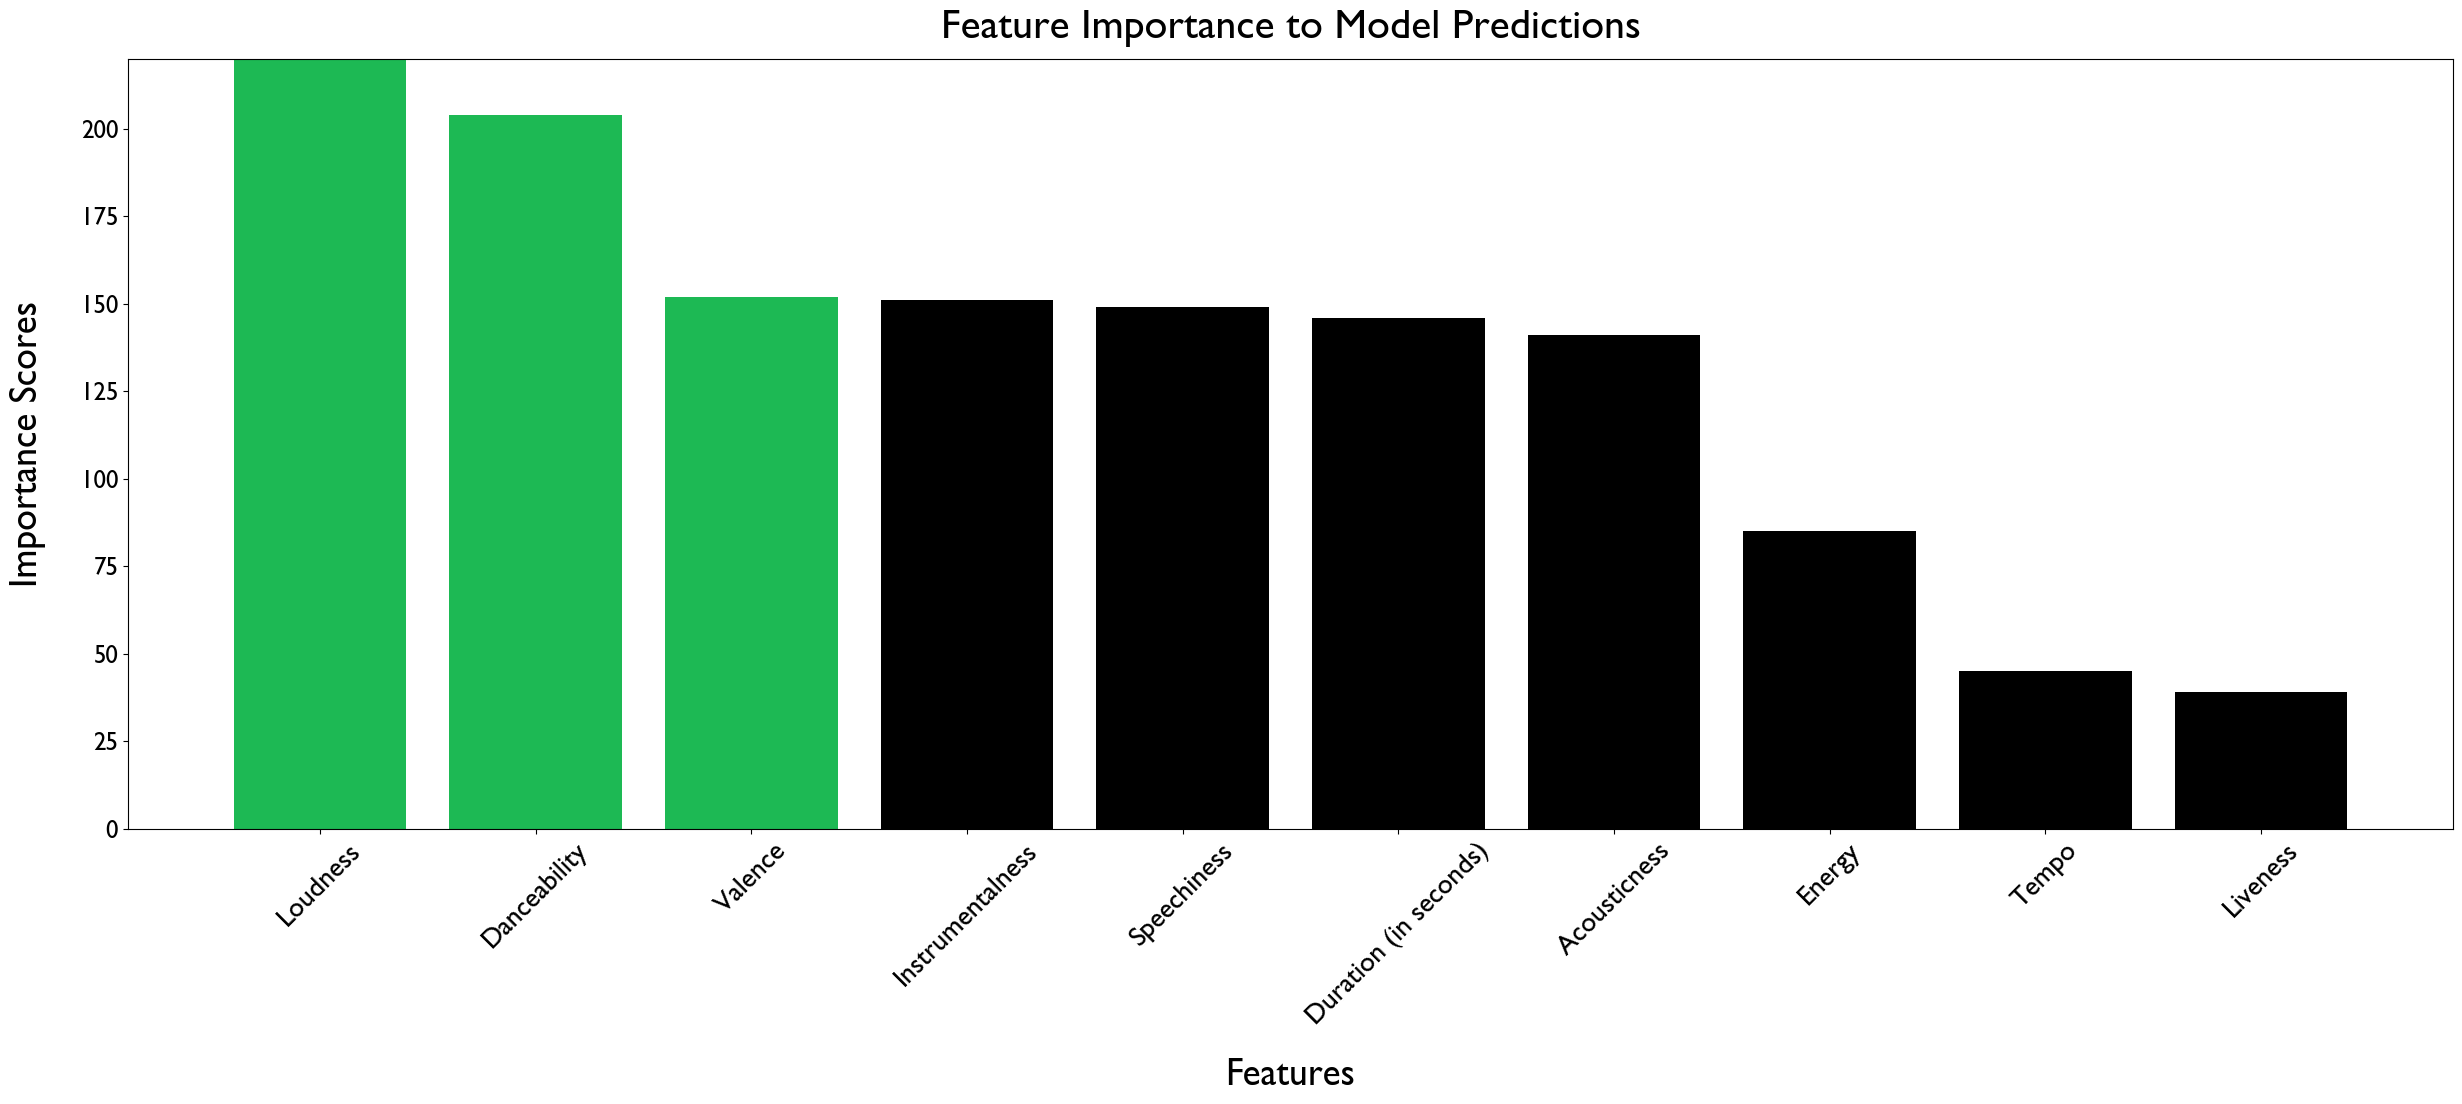

In [108]:
# Visualize Feature Importances with Transparent Bar Graph

# Create variables for chart
features = feature_importance_df['feature_names']
feature_coeffs = feature_importance_df['coeffs']

c = ['#1DB954', '#1DB954','#1DB954', 'black', 'black', 'black', 'black', 'black', 'black', 'black']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (30,10))
bars = ax.bar(x=features, height=feature_coeffs, color= c)
ax.set_xlabel('Features', fontsize=27, labelpad=20) 
ax.set_ylabel('Importance Scores', fontsize=27, labelpad=25)
ax.set_title('Feature Importance to Model Predictions', fontsize=30, pad=15)
ax.tick_params(axis='y', labelsize=18)
#ax.set_yticks(fontsize=12)
ax.set_ylim(0, 220, 20)
ax.set_xticks(features)
ax.set_xticklabels(features, fontsize=20, rotation=45);

plt.savefig('./Visuals/Feature_Importance_BarChart.png', bbox_inches='tight',transparent=True);

### Correct and Incorrect Guesses

#### Find Tweets for TP and FP

##### True Positive

In [109]:
# Create a series of the predictions
y_pred = pd.Series(y_pred_test, name='predictions')

In [110]:
# Recreate dataframe with test data
df_songs = pd.concat([X_test, y_test], axis=1)

In [111]:
# Reset the index, but keep it as a column
df_songs.reset_index(inplace=True)
#df_songs.drop(['index'], axis=1, inplace=True)

In [112]:
# Create a full dataframe with actual vs predicted values
songs_df = pd.concat([df_songs, y_pred], axis=1)

In [131]:
# True Positives (Correctly guessed hit songs)
TP_songs = songs_df.loc[(songs_df['hit'] == 1) & (songs_df['predictions'] == 1)]

In [143]:
# Song: I Just Wanna Dance by Tiagz | ID: 1iRYxEmqvvRHA0CoBPny8b
# Look up song using index to get track ID and info

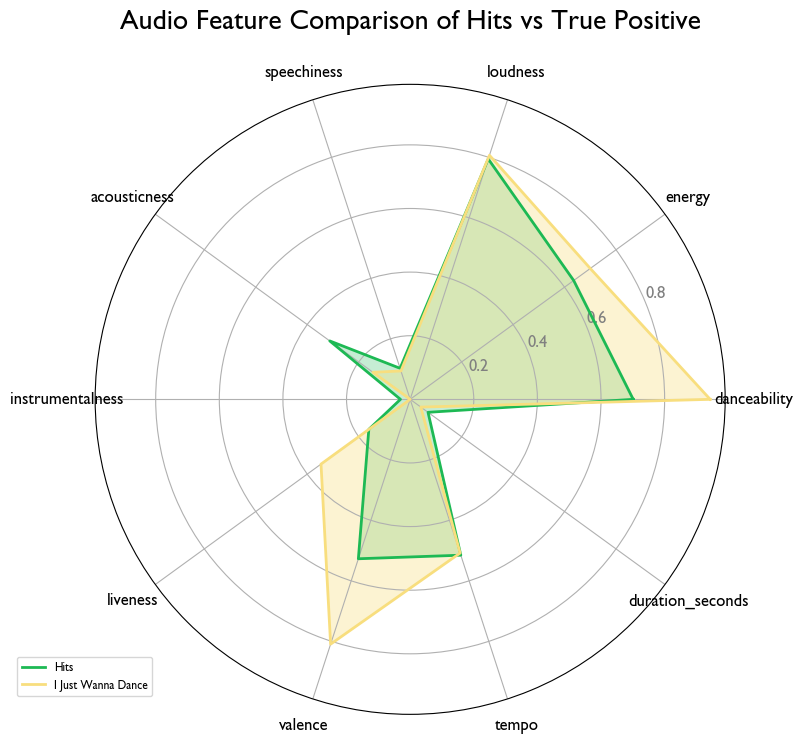

In [233]:
# Create a Radar chart using matplotlib

# Set data
# Convert column names into a list
categories = list(df_radar_hit.columns)
# number of categories
N = len(categories)

# Create a list with the average of all features
value_hit = list(df_radar_hit.mean())
value_tp = list(df_radar_hit.iloc[15])

# Repeat first value to close the circle
# The plot is a circle, so we need to "complete the loop" and append the start value to the end
value_hit+=value_hit[:1]
value_tp+=value_tp[:1]

# Calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(221, polar=True)

#Plot 1 - Hits
ax.plot(angles, value_hit,  linewidth=2, label="Hits", color='#1DB954')
ax.fill(angles, value_hit, alpha=0.25, facecolor='#1DB954')

#Plot 2 - TP
ax.plot(angles, value_tp, linewidth=2, label = "I Just Wanna Dance", color='#F8DE7E')
ax.fill(angles, value_tp, alpha=0.35, facecolor='#F8DE7E')

ax.set_title('Audio Feature Comparison of Hits vs True Positive', size=20, pad=40)
ax.grid(True)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='small')

# Add axis ticks
plt.xticks(angles[:-1],categories, size=12)
ax.tick_params(axis='x', which='major', pad=10)
plt.yticks(color='grey',size=12)


# Create a color palette:
plt.cm.get_cmap("Set2", len(df_radar_hit.index))

# Save Figure
plt.savefig('./Visuals/TruePositive_Radar_Chart.png', bbox_inches='tight',transparent=True)

# Show Figure
plt.show();

##### False Positive

In [178]:
# False Positives (Incorrectly guessed a non-hit song as a hit)
FP_songs = songs_df.loc[(songs_df['hit'] == 0) & (songs_df['predictions'] == 1)]

In [ ]:
# Song: Cloud 9 by Beach Bunny| ID: 2vnB6tuQMaQpORiRdvXF9H
# Look up song using index to get track ID and info

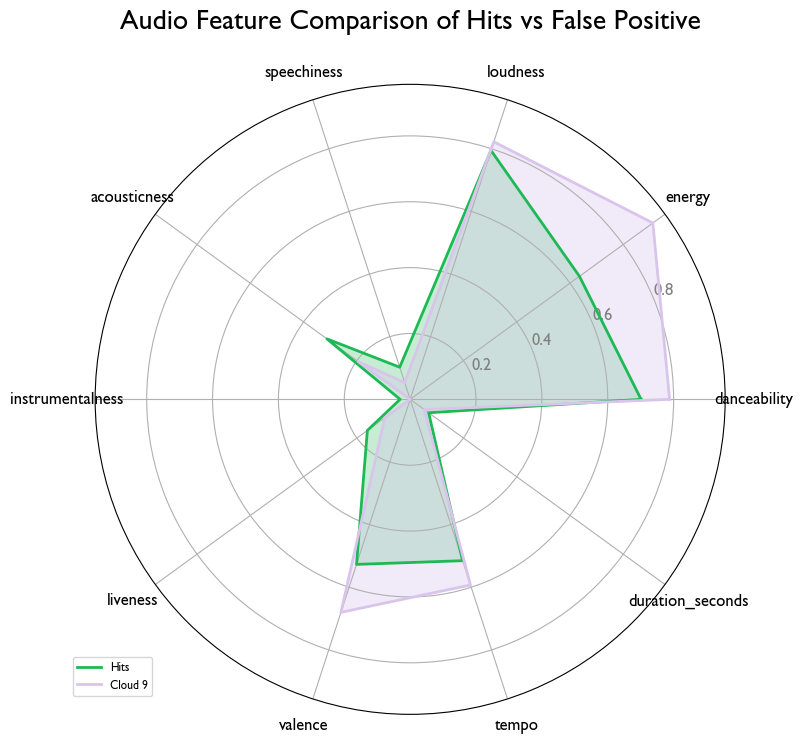

In [234]:
# Create a Radar chart using matplotlib

# Set data
# Convert column names into a list
categories = list(df_radar_hit.columns)
# number of categories
N = len(categories)

# Create a list with the average of all features
value_hit = list(df_radar_hit.mean())
value_fp = list(df_radar_nohit.iloc[34560])

# Repeat first value to close the circle
# The plot is a circle, so we need to "complete the loop" and append the start value to the end
value_hit+=value_hit[:1]
value_fp+=value_fp[:1]

# Calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(221, polar=True)

#Plot 1 - Hits
ax.plot(angles, value_hit,  linewidth=2, label="Hits", color='#1DB954')
ax.fill(angles, value_hit, alpha=0.25, facecolor='#1DB954')

#Plot 2 - FP
ax.plot(angles, value_fp, linewidth=2, label = "Cloud 9", color='#D9C4EC')
ax.fill(angles, value_fp, alpha=0.35, facecolor='#D9C4EC' )

ax.set_title('Audio Feature Comparison of Hits vs False Positive', size=20, pad=40)
ax.grid(True)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='small')

# Add axis ticks
plt.xticks(angles[:-1],categories, size=12)
ax.tick_params(axis='x', which='major', pad=10)
plt.yticks(color='grey',size=12)


# Create a color palette:
plt.cm.get_cmap("Set2", len(df_radar_hit.index))

# Save Figure
plt.savefig('./Visuals/FalsePositive_Radar_Chart.png', bbox_inches='tight',transparent=True)

# Show Figure
plt.show();

##### True Negative

In [ ]:
# True Negatives (correctly guessed a non-hit song)
TN_songs = songs_df.loc[(songs_df['hit'] == 0) & (songs_df['predictions'] == 0)]

In [ ]:
# Song: Calm Embrace by Esa Plant | ID: 5rMCyc5FUpkpAx2MIB9Bja
# Look up song using index to get track ID and info

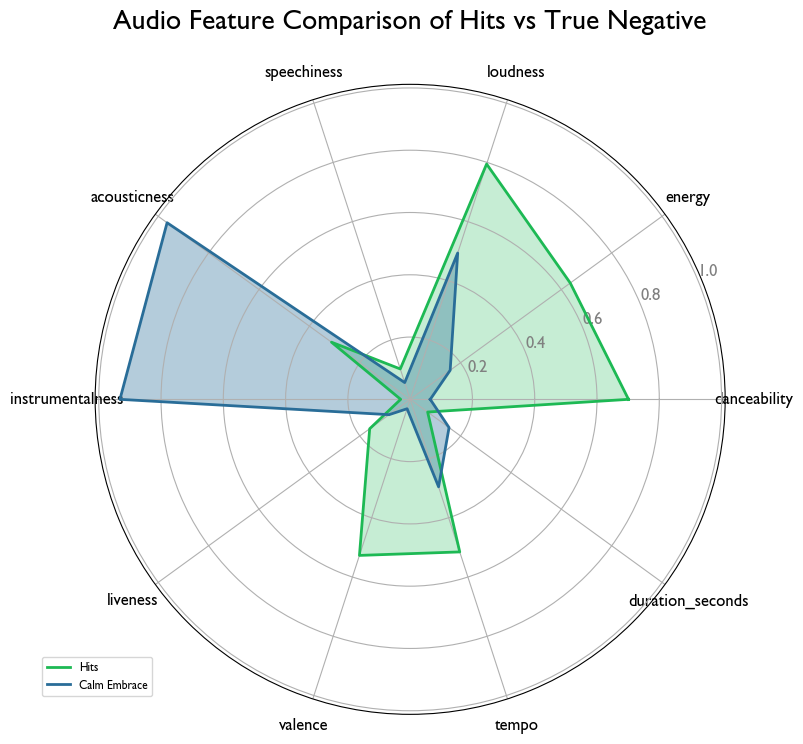

In [231]:
# Create a Radar chart using matplotlib

# Set data
# Convert column names into a list
categories = list(df_radar_hit.columns)
# number of categories
N = len(categories)

# Create a list with the average of all features
value_hit = list(df_radar_hit.mean())
value_tn = list(df_radar_nohit.iloc[54354])

# Repeat first value to close the circle
# The plot is a circle, so we need to "complete the loop" and append the start value to the end
value_hit+=value_hit[:1]
value_tn+=value_tn[:1]

# Calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(221, polar=True)

#Plot 1 - Hits
ax.plot(angles, value_hit,  linewidth=2, label="Hits", color='#1DB954')
ax.fill(angles, value_hit, alpha=0.25, facecolor='#1DB954')

#Plot 2 - FP
ax.plot(angles, value_tn, linewidth=2, label = "Calm Embrace", color='#296d98')
ax.fill(angles, value_tn, alpha=0.35, facecolor='#296d98' )

ax.set_title('Audio Feature Comparison of Hits vs True Negative', size=20, pad=40)
ax.grid(True)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='small')

# Add axis ticks
plt.xticks(angles[:-1],categories, size=12)
ax.tick_params(axis='x', which='major', pad=10)
plt.yticks(color='grey',size=12)


# Create a color palette:
plt.cm.get_cmap("Set2", len(df_radar_hit.index))

# Save Figure
plt.savefig('./Visuals/TrueNegative_Radar_Chart.png', bbox_inches='tight',transparent=True)

# Show Figure
plt.show();

## V. Evaluation
With a final precision score of 90% on unseen data, we can say that our model is doing a very good job at minimizing the amount of incorrect songs it classifies as a hit. To reiterate, this is very important since Spotify wants to be sure that a song they classify as a hit - and therefore put time and money into supporting - actually has potential to be a hit and not a flop. 

### Limitations
With any project comes it's limitations:
* **Not enough data**: After data preparation, I had just over 66,000 rows (songs) in my final dataset. If you recall, 60,000 songs are uploaded daily to Spotify's platform, and there are over 90 million songs on the platform currently. The use of more data can reduce overfitting and better represent Spotify's database. 
* **Features not accounted for have a large impact on song popularity**: Although this analysis only focused on audio features, we can't deny that other factors such as artist popularity, date released, and whether or not they have partnerships with Spotify have massive impacts on song popularity. We can't do anything about this, but it is important to note.
* **High precision but low recall**: We know that recall and precision inversely effect eachother; however, in the future we may want to try to maintain a high precision score without sacraficing too much from precision, thereby increasing accuracy and f1 scores in tandem.

## VI. Conclusions
My hope is  that spotify can use this data to better there company, whether that be through the creation of a record label, or a better understanding of which artists they should support. It is hard to ignore the fact that music is incredibly subjective, and many would argue against the use of data to classify an art that cannot be reduced to numbers and figures but only understood through emotion and feeling. This analysis is not intended to minimize the trained ear that can only be attained from decades in the studio; rather, it highlights an alternative approach to recognize patterns in those  aspects of music that are quantifiable and possibly overlooked. 